In [1]:
%matplotlib inline
#导入相关依赖库
import  os
import numpy as np
from matplotlib import pyplot as plt

import mindspore as ms
#context模块用于设置实验环境和实验设备
import mindspore.context as context
#dataset模块用于处理数据形成数据集
import mindspore.dataset as ds
#c_transforms模块用于转换数据类型
import mindspore.dataset.transforms.c_transforms as C
#vision.c_transforms模块用于转换图像，这是一个基于opencv的高级API
import mindspore.dataset.vision.c_transforms as CV
#导入Accuracy作为评价指标
from mindspore.nn.metrics import Accuracy
#nn中有各种神经网络层如：Dense，ReLu
from mindspore import nn
#Model用于创建模型对象，完成网络搭建和编译，并用于训练和评估
from mindspore.train import Model
#LossMonitor可以在训练过程中返回LOSS值作为监控指标
from mindspore.train.callback import  LossMonitor
#设定运行模式为动态图模式，并且运行设备为昇腾芯片
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig
from mindspore import load_checkpoint, load_param_into_net

In [2]:
#MindSpore内置方法读取MNIST数据集
ds_train = ds.MnistDataset(os.path.join(r'MNIST', "D:/DL/MNIST/MNIST/train"))
ds_test = ds.MnistDataset(os.path.join(r'MNIST', "D:/DL/MNIST/MNIST/test")) 

print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
# 该数据集可以通过create_dict_iterator()转换为迭代器形式，然后通过get_next()一个个输出样本
image=ds_train.create_dict_iterator()._get_next()
print(type(image))
print('图像长/宽/通道数：',image['image'].shape)
#一共10类，用0-9的数字表达类别。
print('一张图像的标签样式：',image['label'])  

训练数据集数量： 60000
测试数据集数量： 10000
<class 'dict'>
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 9


In [3]:
DATA_DIR_TRAIN = "D:/DL/MNIST/MNIST/train" # 训练集信息
DATA_DIR_TEST = "D:/DL/MNIST/MNIST/test" # 测试集信息

In [4]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    #定义改变形状、归一化和更改图片维度的操作。
    #改为（28,28）的形状
    resize_op = CV.Resize(resize)
    #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    #由高度、宽度、深度改为深度、高度、宽度
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    #设定洗牌缓冲区的大小，从一定程度上控制打乱操作的混乱程度
    ds = ds.shuffle(buffer_size=buffer_size)
    #设定数据集的batch_size大小，并丢弃剩余的样本
    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds

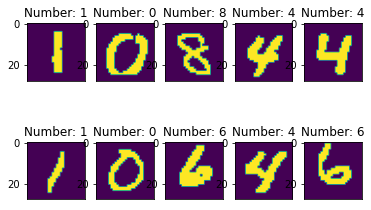

In [5]:
dataset_show = create_dataset(training=False)
data = dataset_show.create_dict_iterator()._get_next()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1,11):
    plt.subplot(2, 5, i)
    #利用squeeze方法去掉多余的一个维度
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])

In [6]:
#利用定义类的方式生成网络，Mindspore中定义网络需要继承nn.cell。在init方法中定义该网络需要的神经网络层
#在construct方法中梳理神经网络层与层之间的关系。
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)   
        output = self.fc4(output)
        output = self.fc5(output)
        output = self.fc6(output)
        return output 

In [7]:
lr = 0.001
num_epoch = 10
momentum = 0.9

net = ForwardNN()
#定义loss函数，改函数不需要求导，可以给离散的标签值，且loss值为均值
loss = nn.loss.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
#定义准确率为评价指标，用于评价模型
metrics={"Accuracy": Accuracy()}
#定义优化器为Adam优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr)

In [8]:
#生成验证集，验证机不需要训练，所以不需要repeat
ds_eval = create_dataset(False, batch_size=32)
#模型编译过程，将定义好的网络、loss函数、评价指标、优化器编译
model = Model(net, loss, opt, metrics)

In [9]:
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpt_cb = ModelCheckpoint(prefix='ForwardNN', directory='D:/DL/MNIST/Mindspore/model',config=config_ck)

In [10]:
#生成训练集
ds_train = create_dataset(True, batch_size=32)
print("============== Starting Training ==============")
#训练模型，用loss作为监控指标，并利用昇腾芯片的数据下沉特性进行训练
model.train(num_epoch, ds_train,callbacks=[LossMonitor(1875), ckpt_cb],dataset_sink_mode=True)

[WARNING] ME(20264:22596,MainProcess):2022-03-22-12:25:23.806.705 [mindspore\train\model.py:550] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.7574810981750488
epoch: 2 step: 1875, loss is 1.6998945474624634
epoch: 3 step: 1875, loss is 1.5861542224884033
epoch: 4 step: 1875, loss is 1.6160986423492432
epoch: 5 step: 1875, loss is 1.722794532775879
epoch: 6 step: 1875, loss is 1.5227510929107666
epoch: 7 step: 1875, loss is 1.5849040746688843
epoch: 8 step: 1875, loss is 1.5549007654190063
epoch: 9 step: 1875, loss is 1.5549014806747437
epoch: 10 step: 1875, loss is 1.5236507654190063


In [11]:
#使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)

[WARNING] ME(20264:22596,MainProcess):2022-03-22-12:33:29.853.157 [mindspore\train\model.py:968] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


{'Accuracy': 0.8895232371794872}


In [12]:
net_test = ForwardNN()
load_checkpoint('D:/DL/MNIST/Mindspore/model/ForwardNN-5_1875.ckpt',net = net_test)
Copymetrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
model_test = Model(net_test, loss,metrics=Copymetrics)
acc = model_test.eval(ds_eval)
acc

[WARNING] ME(20264:22596,MainProcess):2022-03-22-12:33:30.680.959 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(512, 784), dtype=Float32, requires_grad=True)'.
[WARNING] ME(20264:22596,MainProcess):2022-03-22-12:33:30.680.959 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(512,), dtype=Float32, requires_grad=True)'.
[WARNING] ME(20264:22596,MainProcess):2022-03-22-12:33:30.695.968 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(256, 512), dtype=Float32, requires_grad=True)'.
[WARNING] ME(20264:22596,MainProcess):2022-03-22-12:33:30.695.968 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (nam

{'accuracy': 0.8662860576923077,
 'loss': 1.5948245861591437,
 'precision': array([0.97052632, 0.92174629, 0.94485684, 0.92      , 0.87256809,
        0.54707379, 0.97780374, 0.90363815, 0.95348837, 0.88777555]),
 'recall': array([0.94564103, 0.98590308, 0.86504854, 0.61607143, 0.91344196,
        0.96520763, 0.8736952 , 0.89833822, 0.71634121, 0.87809713]),
 'f1_score': array([0.95792208, 0.95274585, 0.90319311, 0.73796791, 0.89253731,
        0.69833536, 0.92282249, 0.90098039, 0.81807512, 0.88290982])}